# Assignment: Linear Models, Regularization, and Model Selection on Real Data

Integrantes:

- Calle Chambe, Efraín

- Poma Huamán, Brayan

- Sánchez Vásquez, Barbara Gabriela

## Part A. Linear Regression From Scratch

1. **Dataset**
   Use the **California Housing dataset** (`from sklearn.datasets import fetch_california_housing`).

   * Create a hold-out test set.
   * Predict the median house value (`MedHouseVal`) from the remaining features.
   * Standardize features to zero mean and unit variance.

In [1]:
# Import basic packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.datasets import fetch_california_housing

In [2]:
# California Housing dataset

rd = fetch_california_housing(as_frame=True)

X = rd.data
y = rd.target # MedianHouseValue

print(X.shape)
print(y.shape)
print("Features:", X.columns.tolist())
print("Target:", y.name)

(20640, 8)
(20640,)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: MedHouseVal


In [3]:
# Hold-out set

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=20)

print(X_train.shape)
print(X_test.shape)


(16512, 8)
(4128, 8)


In [4]:
# Standardize features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Mean: ", X_train_scaled.mean(axis=0))
print("Variance: ", X_train_scaled.std(axis=0))


Mean:  [-8.72471776e-17  8.28901977e-17 -2.51467667e-17 -6.70490795e-17
  6.96040985e-17 -3.99120874e-17 -4.53585812e-15 -2.75108317e-15]
Variance:  [1. 1. 1. 1. 1. 1. 1. 1.]



2. **Closed-form OLS**

   * Derive and implement $\hat\beta = (X^\top X)^{-1}X^\top y$ using only `numpy`.
   * Report coefficients and intercept.
   * Plot predicted vs. true median house value on a held-out test set.
   

**Derivating from RSS to Normal Equation**

We know:

$$
\mathrm{RSS}(\beta) = \|Y - X\beta\|_2^2 = (Y - X\beta)^\top (Y - X\beta)
$$
Also:

$$
\mathrm{RSS}(\beta) = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Where we define the predicted value as
$$
\hat{y}_i = x_i^\top \beta
$$

So:

$$\mathrm{RSS}(\beta) = \sum_{i=1}^{n} (y_i - x_i^\top \beta)^2$$

Deriving:

$$
\frac{\partial\, \mathrm{RSS}(\beta)}{\partial \beta} = -2 \sum_{i=1}^{n} x_i^\top (y_i - x_i^\top \beta)
$$

Matrix form:
$$
\frac{\partial\, \mathrm{RSS}(\beta)}{\partial \beta} = -2 X^\top (Y - X\beta)
$$

F.O.C.

Then, we do $\frac{\partial\, \mathrm{RSS}(\beta)}{\partial \beta} = 0$ to obtain the $\hat{\beta}$ that minimize this loss:

$$
-2 X^\top (Y - X\beta) = 0
$$
$$
X^\top Y - X^\top X \beta = 0
$$

$$
X^\top Y = X^\top X \beta
$$

Then, assuming  $(X^\top X)$ can be inverted, we finally get:

$$
\hat{\beta} = (X^\top X)^{-1} X^\top Y
$$

In [5]:
# Closed-form OLS

X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled] # adding intercept term

beta_hat = np.linalg.inv(X_train_b.T.dot(X_train_b)).dot(X_train_b.T).dot(y_train)

# Report coefficients and intercept

print("Coefficients:", beta_hat[1:])
print("Intercept:", beta_hat[0])

Coefficients: [ 0.83275185  0.1173856  -0.27597663  0.29900186 -0.00795271 -0.03963673
 -0.88241635 -0.85338011]
Intercept: 2.0678235537790446


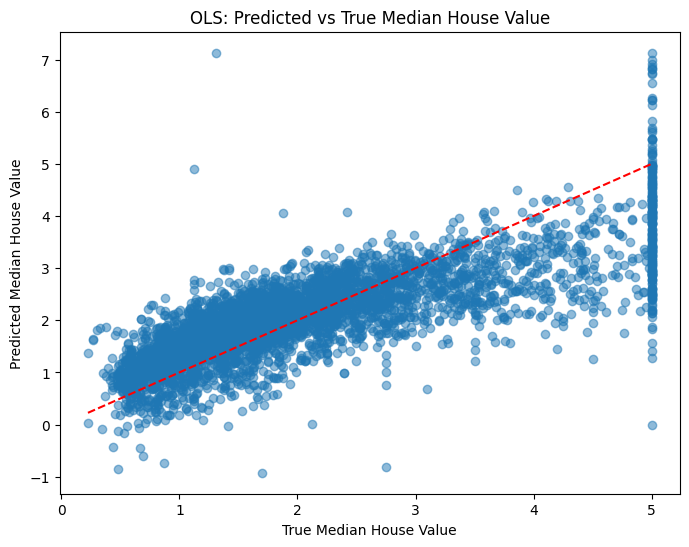

In [6]:
# Plot predicted vs true on test set

X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled] # adding intercept term
y_pred = X_test_b.dot(beta_hat)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("OLS: Predicted vs True Median House Value")
plt.show()

3. **Gradient Descent**

   * Implement gradient descent to minimize mean squared error.
   * Experiment with at least two learning rates; show cost vs. iteration curves.
   * Compare parameters and test error to the closed-form OLS.

In [80]:
# 


## Part B. Scikit-learn Linear Models

4. **Baseline**

   * Use `LinearRegression` and confirm the coefficients match your OLS implementation.



In [10]:
# Entrenar modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Crear DataFrame para comparar coeficientes
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "OLS_from_scratch": beta_hat[1:],
    "LinearRegression_sklearn": lin_reg.coef_
})

# Agregar fila para el intercepto
intercept_df = pd.DataFrame({
    "Feature": ["Intercept"],
    "OLS_from_scratch": [beta_hat[0]],
    "LinearRegression_sklearn": [lin_reg.intercept_]
})

# Concatenar intercepto + coeficientes
coef_table = pd.concat([intercept_df, coef_df], ignore_index=True)

# Mostrar tabla
print(coef_table)

      Feature  OLS_from_scratch  LinearRegression_sklearn
0   Intercept          2.067824                  2.067824
1      MedInc          0.832752                  0.832752
2    HouseAge          0.117386                  0.117386
3    AveRooms         -0.275977                 -0.275977
4   AveBedrms          0.299002                  0.299002
5  Population         -0.007953                 -0.007953
6    AveOccup         -0.039637                 -0.039637
7    Latitude         -0.882416                 -0.882416
8   Longitude         -0.853380                 -0.853380


   * Compute $R^2$ and mean squared error on the test set.  

In [11]:
# Predicciones en test
y_pred_sklearn = lin_reg.predict(X_test_scaled)

# Métricas de desempeño
mse_test = mean_squared_error(y_test, y_pred_sklearn)
r2_test = r2_score(y_test, y_pred_sklearn)

print("\nResultados en el conjunto de prueba:")
print("MSE:", mse_test)
print("R²:", r2_test)


Resultados en el conjunto de prueba:
MSE: 0.5410055769085322
R²: 0.6121654293404898


## Part C. Regularization and Hyperparameter Choice


5. **Ridge and Lasso**

   * Fit `Ridge` and `Lasso` regressions for $\lambda$ values logarithmically spaced between $10^{-3}$ and $10^{2}$.


   * Plot coefficient magnitude vs. $\lambda$ (regularization paths).
   * Comment on which features shrink to (or toward) zero and why.

6. **k-Fold Cross-Validation**

   * Use `KFold` with 5 folds and `cross_val_score` to select the best $\alpha$ for both Ridge and Lasso.
   * Alternatively, demonstrate the convenience of `RidgeCV` and `LassoCV`.
   * Compare cross-validated test errors.

7. **Feature Engineering & Multicollinearity**

  * Add polynomial features (degree 2) using `PolynomialFeatures`.
  * Re-run Ridge/Lasso and discuss how regularization copes with the enlarged feature space.

## Part D. Bike Rentals

8. **Alternative Dataset**

  * Use the **Bike Sharing Dataset** (available in the `data` folder).
  * Predict daily rentals (`cnt`); investigate seasonal effects.
  * Apply all the same steps as above.
